# VaR Techniques

In [99]:
import numpy as np
import pandas as pd
from arch import arch_model
from scipy.stats import norm
import matplotlib.pyplot as plt

### 1. Historical method

#### Historical Var is the bottom 1st percentile of return series

In [44]:
df = pd.read_csv("hw4_returns.csv")
def calc_hist_VaR(df):
    df["Historical VaR"] = 0
    for i in range(len(df)):
        df.loc[i, "Historical VaR"] = min(0, np.percentile(df[:i+1]["Return"], 1))    
    return df
df = calc_hist_VaR(df)
df

,Date,Return,Historical VaR
0,1/2/2014,0.004572,0.000000
1,1/3/2014,0.006045,0.000000
2,1/6/2014,-0.001432,-0.001311
3,1/7/2014,0.015461,-0.001251
4,1/8/2014,0.000763,-0.001344
...,...,...,...
995,12/13/2017,-0.014844,-0.078554
996,12/14/2017,0.037677,-0.078553
997,12/15/2017,0.028865,-0.078552
998,12/18/2017,0.009881,-0.078550


#### Exponential Weighted Var with $ \lambda=0.995 $ 
1. Calculate weights of observation i = $ w_i =  \lambda ^ {n-i} \frac{1-\lambda}{1-\lambda^n}  $ 
2. Sort the return series
3. Calculate cumulative weights 
3. Calculate EW VaR as the observation with cumulative weight just above $ 1-c $ where c = 99%

In [45]:
def ew_VaR_calc(lmda, df):
    ew_l = lmda
    n = len(df)
    df["Weight"] = 0
    for i in range(n):
        df.loc[i, "Weight"] = (ew_l ** (n - i)) * (1-ew_l)/(1-(ew_l ** n))
    ew_df = df.sort_values("Return")
    ew_df = ew_df.reset_index(drop=True)
    ew_df["Cumulative Weight"] = ew_df["Weight"].cumsum()
    ew_VaR = ew_df[ew_df["Cumulative Weight"] > (1-0.99)]["Return"].values[0]
    return ew_VaR
ew_VaR = ew_VaR_calc(0.995, df)
ew_df

,Date,Return,Historical VaR,Weight,Cumulative Weight
0,11/11/2016,-0.196030,-0.078187,0.001249,0.001249
1,9/14/2015,-0.117536,-0.063187,0.000285,0.001534
2,11/14/2017,-0.110664,-0.077319,0.004441,0.005975
3,3/27/2017,-0.108056,-0.078335,0.001971,0.007946
4,11/19/2015,-0.099686,-0.066136,0.000362,0.008308
...,...,...,...,...,...
995,6/12/2015,0.069710,-0.050211,0.000207,0.990899
996,8/2/2017,0.072812,-0.076810,0.003080,0.993979
997,6/8/2015,0.073538,-0.050236,0.000203,0.994181
998,3/22/2016,0.085851,-0.074703,0.000549,0.994731


In [46]:
print("Historical VaR:", abs(df["Historical VaR"][-1:].values[0]))
print("Exponential weighted VaR: ", abs(ew_VaR))

Historical VaR: 0.07854885739
Exponential weighted VaR:  0.082098173


#### Calculate exceptions (where losses exceed VaR) at each data point 

In [40]:
df["Historical Exceptions"] = 0
df["EW Exceptions"] = 0
for i in range(len(df)):
    previous = df[:i]
    df.loc[i, "Historical Exceptions"] = len(previous[previous["Historical VaR"] > previous["Return"]])
    df.loc[i, "EW Exceptions"] = len(previous[previous["Return"] < ew_VaR])
df

,Date,Return,Historical VaR,Weight,Historical Exceptions,EW Exceptions
0,1/2/2014,0.004572,0.000000,0.000033,0,0
1,1/3/2014,0.006045,0.000000,0.000034,0,0
2,1/6/2014,-0.001432,-0.001311,0.000034,0,0
3,1/7/2014,0.015461,-0.001251,0.000034,1,0
4,1/8/2014,0.000763,-0.001344,0.000034,1,0
...,...,...,...,...,...,...
995,12/13/2017,-0.014844,-0.078554,0.004909,26,6
996,12/14/2017,0.037677,-0.078553,0.004934,26,6
997,12/15/2017,0.028865,-0.078552,0.004958,26,6
998,12/18/2017,0.009881,-0.078550,0.004983,26,6


In [41]:
print("Exceptions in Historical VaR:", df["Historical Exceptions"][-1:].values[0])
print("Exceptions in Exponential weighted VaR: ", df["EW Exceptions"][-1:].values[0])

Exceptions in Historical VaR: 26
Exceptions in Exponential weighted VaR:  6


Exponentially weighted VaR performs better than Historical VaR in the backtest

#### Parametric method to estimate VaR confidence interval
1. Calculate the sample standard error of the Returns.
2. Compute the z-score corresponding to the 95% confidence level (approximately 1.96 for a standard normal distribution).
3. Calculate the confidence interval as (VaR - z * SE, VaR + z * SE), where SE = standard error

In [42]:
se = df["Return"].std()/np.sqrt(len(df))
z = 1.96
VaR = df["Historical VaR"][-1:].values[0]
upper = abs(VaR - z*se)
lower = abs(VaR + z*se)
print(f"Confidence Interval of Historical VaR: Parametric estimate: ({lower:.4f}, {upper:.4f})")

Confidence Interval of Historical VaR: Parametric estimate: (0.0770, 0.0801)


#### Bootstrapping method to estimate VaR confidence interval
1. Resample the original returns with replacement (create a new dataset of the same size by randomly selecting observations from the original dataset, allowing for duplicates).
2. Calculate the VaR for the resampled dataset using the corresponding method (historical or EWMA).
3. Repeat this process many times (e.g., 1000 or more) to obtain a distribution of bootstrap VaRs.
4. Calculate the 2.5th and 97.5th percentiles of the bootstrap VaRs to obtain the 95% confidence interval.

In [120]:
precision = 1000
n = len(df)
hist_VaR_dist = []
ew_VaR_dist = []

for i in range(precision):
    sample = df["Return"].sample(n=n, replace=True).values
    sample = pd.DataFrame(sample, columns=['Return'])
    hist_VaR_dist.append(np.percentile(sample["Return"], 1))
    ew_VaR_dist.append(ew_VaR_calc(0.995, sample))

upper1 = abs(np.percentile(hist_VaR_dist, 2.5))
lower1 = abs(np.percentile(hist_VaR_dist, 97.5))
upper2 = abs(np.percentile(ew_VaR_dist, 2.5))
lower2 = abs(np.percentile(ew_VaR_dist, 97.5))
    
print(f"Confidence Interval of Historical VaR: Bootstrap estimate: ({lower1:.4f}, {upper1:.4f})")
print(f"Confidence Interval of EW VaR: Bootstrap estimate: ({lower2:.4f}, {upper2:.4f})")

Confidence Interval of Historical VaR: Bootstrap estimate: (0.0636, 0.0892)
Confidence Interval of EW VaR: Bootstrap estimate: (0.0588, 0.1081)


### 2. Model Building Approach

#### EWMA volatility

In [123]:
df["Volatility"] = df["Return"].expanding().std()
df["EWMA Volatilty"] = df["Volatility"].ewm(alpha=0.94).mean()
df["EWMA Vol VaR"] = (df["Volatility"] * -2.326)
df

,Date,Return,Historical VaR,Weight,Volatility,EWMA Volatilty,EWMA Vol VaR,GARCH Vol,GARCH Vol VaR,Rolling Volatility,Normalized Return,Modified Historical VaR
0,2014-01-02,0.004572,0.000000,0.000033,NaN,NaN,NaN,0.010150,-0.023612,0.000000,0.000000,-0.000000
1,2014-01-03,0.006045,0.000000,0.000034,0.001042,0.001042,-0.002424,0.010368,-0.024120,0.001042,5.801576,-0.002985
2,2014-01-06,-0.001432,-0.001311,0.000034,0.003960,0.003795,-0.009212,0.010654,-0.024786,0.003960,-0.361469,-0.011346
3,2014-01-07,0.015461,-0.001251,0.000034,0.006992,0.006801,-0.016264,0.010620,-0.024707,0.006992,2.211145,-0.020033
4,2014-01-08,0.000763,-0.001344,0.000034,0.006519,0.006536,-0.015163,0.011901,-0.027687,0.006519,0.117063,-0.018677
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2017-12-13,-0.014844,-0.078554,0.004909,0.025203,0.025203,-0.058621,0.020913,-0.048650,0.028236,-0.525723,-0.080895
996,2017-12-14,0.037677,-0.078553,0.004934,0.025221,0.025220,-0.058664,0.020372,-0.047391,0.029041,1.297361,-0.083202
997,2017-12-15,0.028865,-0.078552,0.004958,0.025227,0.025227,-0.058679,0.023092,-0.053720,0.029772,0.969560,-0.085295
998,2017-12-18,0.009881,-0.078550,0.004983,0.025217,0.025218,-0.058656,0.023993,-0.055815,0.029766,0.331962,-0.085278


#### GARCH volatility

In [124]:
# Specify and fit the GARCH model
garch_model = arch_model(df["Return"], vol='Garch', p=1, q=1, dist='Normal', rescale=False)
results = garch_model.fit()

# Calculate the conditional volatility
df["GARCH Vol"] = results.conditional_volatility

# Calculate the 1-day 99% VaR
confidence_level = 0.99
z_score = norm.ppf(confidence_level)
VaR = df["Return"].expanding().mean() - df["GARCH Vol"] * z_score * -1

# Add VaR to the original data
df['GARCH Vol VaR'] = VaR
df

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.375637235506356e+16
Iteration:      2,   Func. Count:     18,   Neg. LLF: 5783.7075089800455
Iteration:      3,   Func. Count:     28,   Neg. LLF: 38305511.363656774
Iteration:      4,   Func. Count:     40,   Neg. LLF: 161657975.96417618
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2338.321582032141
            Iterations: 4
            Function evaluations: 47
            Gradient evaluations: 4


,Date,Return,Historical VaR,Weight,Volatility,EWMA Volatilty,EWMA Vol VaR,GARCH Vol,GARCH Vol VaR,Rolling Volatility,Normalized Return,Modified Historical VaR
0,2014-01-02,0.004572,0.000000,0.000033,NaN,NaN,NaN,0.010150,0.028184,0.000000,0.000000,-0.000000
1,2014-01-03,0.006045,0.000000,0.000034,0.001042,0.001042,-0.002424,0.010368,0.029429,0.001042,5.801576,-0.002985
2,2014-01-06,-0.001432,-0.001311,0.000034,0.003960,0.003795,-0.009212,0.010654,0.027847,0.003960,-0.361469,-0.011346
3,2014-01-07,0.015461,-0.001251,0.000034,0.006992,0.006801,-0.016264,0.010620,0.030868,0.006992,2.211145,-0.020033
4,2014-01-08,0.000763,-0.001344,0.000034,0.006519,0.006536,-0.015163,0.011901,0.032769,0.006519,0.117063,-0.018677
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2017-12-13,-0.014844,-0.078554,0.004909,0.025203,0.025203,-0.058621,0.020913,0.046693,0.028236,-0.525723,-0.080895
996,2017-12-14,0.037677,-0.078553,0.004934,0.025221,0.025220,-0.058664,0.020372,0.045474,0.029041,1.297361,-0.083202
997,2017-12-15,0.028865,-0.078552,0.004958,0.025227,0.025227,-0.058679,0.023092,0.051834,0.029772,0.969560,-0.085295
998,2017-12-18,0.009881,-0.078550,0.004983,0.025217,0.025218,-0.058656,0.023993,0.053940,0.029766,0.331962,-0.085278


In [125]:
garch_VaR = abs(df['GARCH Vol VaR'][-1:].values[0]) * 100
ewma_VaR = abs(df['EWMA Vol VaR'][-1:].values[0]) * 100
print(f"GARCH based volatility VaR {garch_VaR:.3f}%")
print(f"EWMA based volatility VaR {ewma_VaR:.3f}%")

GARCH based volatility VaR 5.182%
EWMA based volatility VaR 5.863%


The EWMA model is a gives a more conservative estimate of the VaR compared to GARCH(1,1)

### 3. Mixed Approach
1. Calculate rolling volatility with a window of 1 month
2. Normalize the gains

Text(0.5, 1.0, 'Normalized Return')

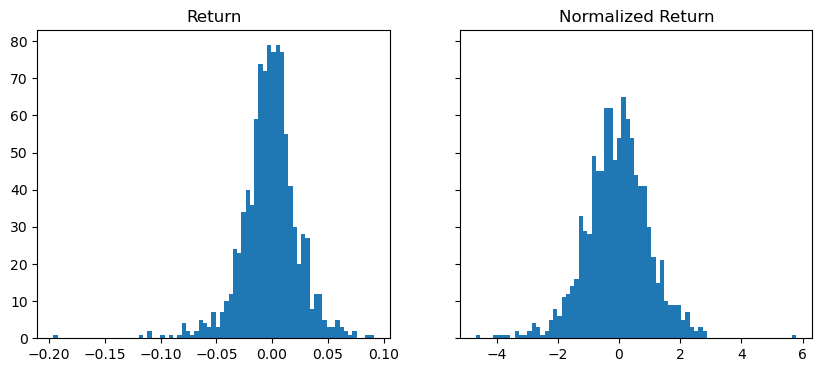

In [128]:
df["Date"] = pd.to_datetime(df["Date"])
df["Rolling Volatility"] = df["Return"].rolling(window=30).std()
df["Rolling Volatility"].fillna(df["Return"].expanding().std(), inplace=True)
df.fillna(0, inplace=True)
df["Normalized Return"] = df["Return"]/df["Rolling Volatility"]
df['Normalized Return'].replace([np.inf, -np.inf], 0, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].hist(df["Return"], bins=75)
axs[0].set_title("Return")
axs[1].hist(df["Normalized Return"], bins=75)
axs[1].set_title("Normalized Return")

Normalized returns have fatter tails compared to original series

#### Modified Historical VaR using normalized returns

In [129]:
c = 0.99

# Sort the normalized returns
sorted_normalized_returns = df['Normalized Return'].sort_values()

# Determine the quantile corresponding to the (1 - confidence_level)
quantile = sorted_normalized_returns.quantile(1 - c)

# Calculate the VaR in the original return scale for each day
df['Modified Historical VaR'] = df['Rolling Volatility'] * quantile
df

,Date,Return,Historical VaR,Weight,Volatility,EWMA Volatilty,EWMA Vol VaR,GARCH Vol,GARCH Vol VaR,Rolling Volatility,Normalized Return,Modified Historical VaR
0,2014-01-02,0.004572,0.000000,0.000033,0.000000,0.000000,0.000000,0.010150,0.028184,0.000000,0.000000,-0.000000
1,2014-01-03,0.006045,0.000000,0.000034,0.001042,0.001042,-0.002424,0.010368,0.029429,0.001042,5.801576,-0.002985
2,2014-01-06,-0.001432,-0.001311,0.000034,0.003960,0.003795,-0.009212,0.010654,0.027847,0.003960,-0.361469,-0.011346
3,2014-01-07,0.015461,-0.001251,0.000034,0.006992,0.006801,-0.016264,0.010620,0.030868,0.006992,2.211145,-0.020033
4,2014-01-08,0.000763,-0.001344,0.000034,0.006519,0.006536,-0.015163,0.011901,0.032769,0.006519,0.117063,-0.018677
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2017-12-13,-0.014844,-0.078554,0.004909,0.025203,0.025203,-0.058621,0.020913,0.046693,0.028236,-0.525723,-0.080895
996,2017-12-14,0.037677,-0.078553,0.004934,0.025221,0.025220,-0.058664,0.020372,0.045474,0.029041,1.297361,-0.083202
997,2017-12-15,0.028865,-0.078552,0.004958,0.025227,0.025227,-0.058679,0.023092,0.051834,0.029772,0.969560,-0.085295
998,2017-12-18,0.009881,-0.078550,0.004983,0.025217,0.025218,-0.058656,0.023993,0.053940,0.029766,0.331962,-0.085278


The modified historical VaR using the normalized returns approach is $ 8.435\% $

## Proposal for measuring portfolio risk in real time

Following is a comprehensive approach to measuring the risk of our current trade in real-time, using a combination of methods to ensure accuracy and robustness. This proposal outlines the steps and justifies the choices made.

### Historical VaR and Exponential Weighted VaR

Calculate the historical VaR and the exponential weighted VaR (with λ=0.995) for each day in the dataset. Backtest the measures and compare the number of exceptions. The exponential weighted VaR performs better than the historical VaR in the backtest.

### Model-Building Approach

Calculate volatility using the EWMA model with λ=0.94 and the GARCH(1,1) model. Compute the corresponding measures of VaR for both models. The EWMA model provides a more conservative estimate of VaR compared to the GARCH(1,1) model.

### Mixed Approach (Normalized Returns)

Calculate the rolling volatility with a window of 1 month and normalize the gains. Use the modified historical VaR method with the normalized returns to estimate the VaR, accounting for changes in volatility over time. 

### Final Recommendation
It is recommended to incorporate the following real-time risk measurement strategy. Use the Exponential Weighted VaR as the primary risk measure due to its superior backtesting performance. Incorporate the EWMA model as a secondary risk measure for a conservative estimate of VaR. Employ the mixed approach with normalized returns as an additional risk measure, capturing the changes in volatility over time.

### Pith
This combination of risk measures will provide a comprehensive view of the trade's risk and ensure robustness in our risk assessment. By continuously monitoring these measures, we can make well-informed decisions to manage the trade's risk effectively.